# Class 16:  Bayesian Networks
## Infer a Bayesian network from a matrix of discretized phospho-flow cytometry data.
### Based on supplementary data from the 2005 article by Karen Sachs et al. (Science v308, 2005).

In this class exercise, we will use the fundamental theorem for the likelihood of a Bayesian network structure for categorical variables, in order to score the posterior probability of the network shown in the Sachs et al. article (Figure 3A) vs. the phospho-flow cytometry data that the same authors provided in their supplementary data. The phospho-flow cytometry data have been already discretized for you (see "class16_bayesnet_dataprep_R.ipynb").  We will need to implement a single-vertex log-likelihood function using Theorem 1 from the article by Cooper & Herskovits in *Machine Learning* (volume 9, pages 309-347, 1992).

For this notebook, we will need the Python packages `numpy`, `pandas`, `math`, `scipy.special`, `matplotlib.pyplot`, `cairo` and `igraph`.

In [ ]:
import numpy as np
import pandas as pd
import math, scipy.special
import matplotlib.pyplot as plt
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
import cairo
!pip install python-igraph
import igraph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libgif-dev is already the newest version (5.1.9-2build2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


We will also need to download the file `sachs_data_discretized.txt` from the URL

https://csx46.s3-us-west-2.amazonaws.com/sachs_data_discretized.txt.

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/sachs_data_discretized.txt > sachs_data_discretized.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  530k  100  530k    0     0  1164k      0 --:--:-- --:--:-- --:--:-- 1164k


Load the tab-delimited data file of discretized phosphoprotein expression data (12 columns; first 11 columns are the expression levels -- "low", "medium", "high"; last column is the experiment identifier for the row; there are nine experiments). Print out the first six lines of the data frame, so you can see what it looks like.

In [ ]:
discret_data = pd.read_csv("sachs_data_discretized.txt",
                           sep="\t")
discret_data.head(n=6)

,praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk,expt
0,low,low,low,low,high,low,low,medium,medium,high,high,1_cd3cd28
1,low,low,medium,low,low,medium,medium,medium,low,low,high,1_cd3cd28
2,medium,high,medium,low,medium,medium,medium,medium,medium,medium,medium,1_cd3cd28
3,medium,high,medium,low,low,low,low,medium,medium,medium,medium,1_cd3cd28
4,low,medium,low,low,medium,medium,medium,low,low,medium,high,1_cd3cd28
5,low,low,medium,low,low,medium,medium,medium,medium,high,high,1_cd3cd28


How many distinct experiments are there?  Use `pandas.DataFrame.drop_duplicates` on the `expt` column of the data frame.

In [ ]:
discret_data["expt"].drop_duplicates()

0                1_cd3cd28
853         2_cd3cd28icam2
1755    3_cd3cd28+aktinhib
2666       4_cd3cd28+g0076
3389     5_cd3cd28+psitect
4199       6_cd3cd28+u0126
4998          7_cd3cd28+ly
5846                 8_pma
6759              9_b2camp
Name: expt, dtype: object

Define a function `log_prob_network_prior` that computes a log probability prior for a graph structure, based on the vertex degree distribution. The function should take a single argument `network`, of type `numpy.ndarray`.  Details on how to implement the function are given as comments below.

In [ ]:
def log_prob_network_prior(network: np.ndarray):
    # Compute a vector `degarray` of floating point values for the degree
    # of each vertex.
    degarray = np.array(np.sum(network, axis=0) + np.sum(network, axis=1),
                        dtype='float')

    # The log probability is the logarithm of the product (over all vertices) of
    # the single-vertex power-law degree distribution, which we will define as
    # `1/(1+k)^2`.  Remember that the log of the product is the sum of the logs,
    # so you can just compute this as `numpy.sum` of `numpy.log` of
    # `numpy.power(1.0 + degarray, -2)`
    return np.sum(np.log(np.power(1.0 + degarray, -2)))

Define a vectorized log-factorial function `lfactorial`, that takes an argument `n` of type `numpy.ndarray`. Use the fact that `factorial(n) = gamma(n+1)`, where `gamma` means the gamma function. Note that we can compute log gamma as `scipy.special.gammaln`. Can you speculate why we are not implementing factorial directly, and instead computing log factorial?

In [ ]:
def lfactorial(n):
    return scipy.special.gammaln(n+1)

Test out your `lfactorial` function by running it on `np.array([1,2,3,4,5])` and exponentiating the result using `numpy.exp`. Did you get what you expect?

In [ ]:
np.exp(lfactorial(np.array(range(1,6))))

array([  1.,   2.,   6.,  24., 120.])

Define a log likelihood function for a single vertex, based on Theorem 1 in the 1992 article in *Machine Learning* by Cooper & Herskovits. Note:  we are using igraph's adjacency matrix format which is the transpose of Newman's adjacency matrix definition!

In [ ]:
def log_likelihood_network_vertex(network: np.ndarray,
                                  vertex: int,
                                  discret_data: pd.DataFrame):

    # network is a NxN numpy matrix (N = 11 vertices)
    # vertex is an integer vertex ID
    # discret_data is the discretized data (N = 11 vertices, M = 7466 samples)

    # get the ids of the parent of vertex `vertex` by finding which row
    # numbers of `network` have a value 1, in column `vertex`
    parents_vertex = np.where(network[:,vertex]==1)[0].tolist()
    # make a new list `all_vertices` as a copy of `parents_vertex`
    all_vertices = parents_vertex.copy()
    # add the child vertex `vertex` to `all_vertices`
    all_vertices.append(vertex)

    # Using `pandas.DataFrame.iloc`, subset the dataframe `discret_data` in
    # order to select the columns `all_vertices`, as a new dataframe `df1`.
    df1 = discret_data.iloc[:, all_vertices]

    # in `df1`, rename the vertex column to `vertex`; note that `vertex`
    # will be the rightmost column at this point
    df1.columns = [*df1.columns[:-1], "vertex"]

    # get a list of column names of `df1`, as variable `col_names`
    col_names = df1.columns.values.tolist()

    # By chaining method calls to `pandas.DataFrame.groupby`,
    # `pandas.core.groupby.generic.DataFrameGroupBy.size`, and
    # `pandas.Series.reset_index`, count the number of times
    # each unique row appears in the dataframe `df1`,
    # and name resulting row-counts column `count`; replace
    # `df1` with the result of this triple-chain of method calls
    df1 = df1.groupby(col_names).size().reset_index(name='count')

    # in `df1`, make a new column called `countfactorial` that will contain
    # the log of the factorial of the value in the `count` column (which you
    # should compute using your vectorized log-factorial function)
    df1["countfactorial"] = lfactorial(df1["count"].values)

    # using `pandas.DataFrame.drop`drop the "count" column from `df1`
    # (don't forget to specify `axis=1`)
    df1 = df1.drop("count", axis=1)

    # if parents_vertex is nonempty:
    if parents_vertex:
        # compute the number of parent vertices, as variable `num_parents`
        num_parents = len(parents_vertex)

        # Using `range` and `pandas.DataFrame.columns` and
        # `pandas.DataFrame.groupby` (with `as_index=False`), and
        # `pandas.core.groupby.generic.DataFrameGroupBy.sum` (with
        # `numeric_only=True` for the `sum` method call),
        # for each combination of states of the parent vertices, sum the
        # `countfactorial` column over all states of `vertex`
        nijkdf = df1.groupby(by=df1.columns[range(0, num_parents)].tolist(),
                             as_index=False).sum(numeric_only=True)

        # sanity-check that there is no longer a column `vertex` in `df1`,
        # using an assertion
        assert 'vertex' not in nijkdf.columns.tolist()

        # create a dataframe `df3` containing the subset of columns of
        # `discret_data` corresponding to the parent vertices of `vertex`
        df3 = discret_data.iloc[:, parents_vertex]

        # starting from `df3`, create a dataframe `nijdf` containing
        # the counts of unique rows, by chaining together method calls
        # `pandas.DataFrame.groupby` (with `by=df3.columns.values.tolist()` and
        # `as_index=False`), `pandas.core.groupby.generic.DataFrameGroupBy.sum`,
        # and `pandas.DataFrame.reset_index`.
        nijdf = df3.groupby(by=df3.columns.values.tolist(),
                            as_index=False).size().reset_index()

        # set last column name of `nijdf` to `count` (see the trick using the
        # unpacking operator above, where we set the name of the last column
        # of dataframe `df1`)
        nijdf.columns = [*nijdf.columns[:-1], "count"]

        # in dataframe `nijdf`, make a new column `countfactorial` which will
        # contain `log(2)` minus the log of the factorial of the sum of two and
        # the value of the `counts` column of the same dataframe; in pseudocode:
        #    countfactorial := log(2) - logfactorial(2 + count)
        nijdf["countfactorial"] = math.log(2) - lfactorial(2 + nijdf["count"])

        # drop the "count" column from `nijdf`, using `pandas.DataFrame.drop`
        nijdf = nijdf.drop("count", axis=1)

        # use `pandas.DataFrame.merge` to join `nijdf` and `nijkdf` on the
        # parent vertices (i.e., `nijkdf.columns[:-1]`), into two columns
        # `countfactorial_x` and `countfactorial_y` in a single dataframe
        # `nmerge` (use `how="outer"` and `copy=False`, in the merge operation):
        nmerge = nijdf.merge(nijkdf, how="outer",
                             on=nijkdf.columns[:-1].values.tolist(),
                             copy=False)

        # add the two columns `countfactorial_x` and `countfactorial_y` of
        # dataframe `nmerge` and then perform a column-wise sum
        # to get a single floating-point value; assign it to `llh_res`
        llh_res = np.sum(nmerge["countfactorial_x"] + nmerge["countfactorial_y"])
    else:
        # we handle the case of no parent vertices specially, to simplify the code

        # compute the number of rows of `dicreate_data`
        M = discret_data.shape[0]

        # compute log(2) - log((M+2)!) + (the columnwise sum of "countfactorial" in df1)
        llh_res = math.log(2) - lfactorial(M + 2) + np.sum(df1["countfactorial"].values)

    return llh_res

Define a log-posterior-probability function for the whole graph, using the per-vertex likelihood and the network structure prior:

In [ ]:
def log_posterior_prob_network(network: np.ndarray,
                               discret_data: pd.DataFrame):
    # get the count of vertices, as variable `Nvert`
    Nvert = network.shape[1]

    # use list comprehension to obtain the single-vertex log-likelihood for each
    # vertex from 0...Nvert, and assign the resulting list to variable
    # `lpvert_values`
    lpvert_values = [log_likelihood_network_vertex(network, i, discret_data) for
                     i in range(0, Nvert)]

    # compute the joint prior probability on the network, by calling
    # the function `log_prob_network_prior` and passing the `network` to it
    log_joint_prior = log_prob_network_prior(network)

    # compute the joint likelihood as the sum of values in the list `lpvert_values`
    log_joint_likelihood = np.sum(np.array(lpvert_values))

    # return the sum of the log-joint-likelihood and the log-joint-prior
    return log_joint_likelihood + log_joint_prior

Define an adjacency matrix for the "real" network shown in Fig. 3A of the Sachs et al. article (not including the "missed" edges which are the dotted arcs).

In [ ]:
real_network_adj_np = np.zeros(shape=[11,11])
molec_names = list(discret_data.columns)[0:11]
real_network_adj_df = pd.DataFrame(real_network_adj_np, index=molec_names, columns=molec_names)
real_network_adj_df["PKA"]["PKC"] = 1
real_network_adj_df["praf"]["PKC"] = 1
real_network_adj_df["pjnk"]["PKC"] = 1
real_network_adj_df["P38"]["PKC"] = 1
real_network_adj_df["pjnk"]["PKA"] = 1
real_network_adj_df["P38"]["PKA"] = 1
real_network_adj_df["praf"]["PKA"] = 1
real_network_adj_df["pmek"]["PKA"] = 1
real_network_adj_df["p44.42"]["PKA"] = 1  # NOTE: p44.42 = ERK
real_network_adj_df["pakts473"]["PKA"] = 1
real_network_adj_df["pakts473"]["p44.42"] = 1
real_network_adj_df["pmek"]["PKC"] = 1
real_network_adj_df["pmek"]["praf"] = 1
real_network_adj_df["p44.42"]["pmek"] = 1
real_network_adj_df["PIP2"]["plcg"] = 1
real_network_adj_df["PIP3"]["plcg"] = 1
real_network_adj_df["PIP2"]["PIP3"] = 1
real_network_adj = real_network_adj_df.values

Take a look at the dataframe that you have just created

In [ ]:
real_network_adj_df

,praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk
praf,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pmek,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
plcg,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PIP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PIP3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p44.42,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
pakts473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PKA,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
PKC,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
P38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Make an igraph network out of the adjacency matrix that you just created, and print the network summary and plot the network.

In [ ]:
real_network_igraph = igraph.Graph.Adjacency(real_network_adj.tolist())
real_network_igraph.summary()

'IGRAPH D--- 11 17 -- '

Draw the network (you may want to use a larger-than-usual bounding box, say, `bbox=[0, 0, 400, 400]`).

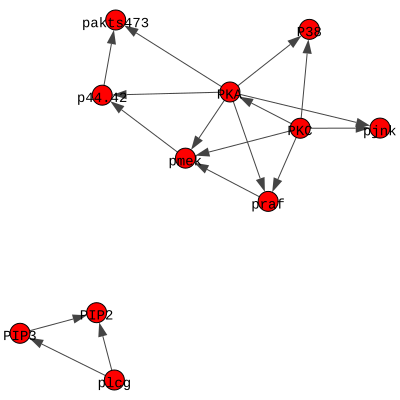

In [ ]:
igraph.drawing.plot(real_network_igraph, bbox=[0, 0, 400, 400],
                    vertex_label=real_network_adj_df.columns.tolist())

Compute the log posterior probability of the real network `real_network_adj` from Sachs *et al.* Figure 3A, using your function `log_posterior_prob_network`.

In [ ]:
lp_real = log_posterior_prob_network(real_network_adj, discret_data)
print(f"{lp_real:0.2f}")

-84131.03


Generate 1000 random rewirings of the network -- eliminating any rewired digraphs that contain cycles -- and for each randomly rewired network compute the log posterior probability. Use `igraph.Graph.rewire_edges(prob=1, loops=False, multiple=False)` to randomly rewire the graph. Make sure to make a copy of the graph before you rewire it. Check that the rewired graph is a DAG using `igraph.Graph.is_dag()`. If it is a DAG, compute the log posterior probability of the network using `log_posterior_prob_network`. You can get the adjacency matrix for the random graph as a numpy array using `numpy.array(randgraph.get_adjacency().data)`  

In [ ]:
lprobs_rand = []
for _ in range(0, 1000):
    graphcopy = real_network_igraph.copy()
    graphcopy.rewire_edges(prob=1, loops=False, multiple=False)
    if graphcopy.is_dag():
        lprobs_rand.append(log_posterior_prob_network(np.array(graphcopy.get_adjacency().data),
                                                      discret_data))

Histogram the log ratio of the "real" network's posterior probability to the posterior probabilities of each of the random networks. Does it appear that the published network is a reasonable approximation to the maximum *a posteriori* (MAP) estimate?  

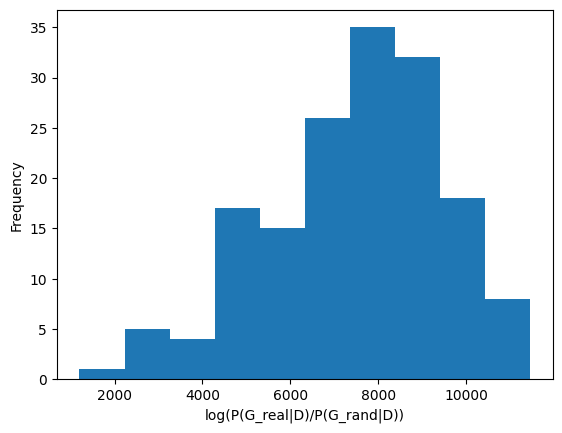

In [ ]:
import matplotlib.pyplot
plt.hist(lp_real - lprobs_rand)
plt.xlabel("log(P(G_real|D)/P(G_rand|D))")
plt.ylabel("Frequency")
plt.show()